In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import dates as mdates
from datetime import datetime

In [93]:
df = pd.read_csv('./AH2023_Sylvania_1yr.csv')
df.head()

,Date time,Swdown,Lwdown,Rainf,Tair,Qair,Wind,Psurf,Ccov,Rnet,Qle,Qh,Qle (LSM),Qh (LSM)
0,2002/01/01 01:00,0.0,216.675,0.0,258.501,0.001170,2.588,94390.867,0.145,-29.267,0.833,-21.168,2.456,59.579
1,2002/01/01 01:30,0.0,216.936,0.0,258.576,0.001181,2.490,94392.797,0.132,-21.540,0.186,-13.835,1.922,46.012
2,2002/01/01 02:00,0.0,217.215,0.0,258.660,0.001192,2.320,94394.953,0.240,-22.932,0.296,-1.749,1.563,35.741
3,2002/01/01 02:30,0.0,218.276,0.0,258.992,0.001227,2.214,94403.469,0.211,-11.259,1.723,-12.495,1.247,26.644
4,2002/01/01 03:00,0.0,218.888,0.0,259.183,0.001247,2.344,94408.359,0.654,-28.586,1.821,-13.398,1.048,22.566


### Variables

|  Variable  |  Name                                   |  Unit     |
| ----       | ----                                    | ----      |
|  Swdown    |  Downward shortwave radiation           |  W/m^2    |
|  Lwdown    |  Downward longwave radiation            |  W/m^2    |
|  Rainf     |  Precipitation                          |  kg/m^2/s |
|  Tair      |  Near surface air temperature           |  K        |
|  Qair      |  Near surface specific humidity         |  kg/kg    |
|  Wind      |  Near surface wind speed                |  m/s      |
|  Psurf     |  Surface Pressure                       |  Pa       |
|  Ccov      |  Total cloud fraction                   |  -        |
|  Rnet      |  Net radiation                          |  W/m^2    |
|  Qle       |  Latent heat flux                       |  W/m^2    |
|  Qh        |  Sensible heat flux                     |  W/m^2    |
|  Qle (LSM) |  Simulated latent heat flux by a LSM    |  W/m^2    |
|  Qh (LSM)  |  Simulated sensible heat flux by a LSM  |  W/m^2    |


In [120]:
# define variables 
day_start = 0
day_end = day_start + 48*6
T = df['Tair'][day_start:day_end]
SH = df['Qair'][day_start:day_end]
WIND = df['Wind'][day_start:day_end]
PRES = df['Psurf'][day_start:day_end]
RN = df['Rnet'][day_start:day_end]
date = [datetime.strptime(date_time,"%Y/%m/%d %H:%M") for date_time in df['Date time'][day_start:day_end]]

In [121]:
#tenson's equation
#E(t) = 6.1078×10^(7.5t/(t+237.3)) T(℃)
def E(t):
    res = 6.1078 * 10 **(7.5*t/(t+237.3))
    return res
def calc_derivative(func,t):
    i = 1;a = 0;diff=1
    while abs(diff) > 1e-6:
        dt = 1/(10**i)
        res = (func(t+dt) -func(t-dt))/(2*dt)
        diff = res -a
        a = res
        i+=1
    return res

def QS(t,psurf=0):
    es = E(t)
    res = 0.622 * (es/psurf)/(1-0.378*(es/psurf))
    return res

def calc_derivative_QS(func,t,psurf):
    i = 1;a = 0;diff=1
    while abs(diff) > 1e-6:
        dt = 1/(10**i)
        res = (func(t+dt,psurf=psurf) -func(t-dt,psurf=psurf))/(2*dt) #中心差分が収束が早い
        diff = res -a
        a = res
        i+=1
    return res
    

In [122]:
# wind function
def wind_func(wind):
    return wind/1000

In [123]:
#Penman's equation
def Penman(T,SH,WIND,PRES,RN):
    cp = 4.178 * 10**3 #J/（kg ･ K）


    #地中熱フラックスは無視する？
    LE = np.zeros(len(T))
    RH = np.zeros(len(T))
    for i,t in enumerate(T):
        i += day_start
        t = t-273.15 #以降セ氏
        #firstly,calculate es and qs
        qs = QS(t,psurf=PRES[i]/100)
        
        delta = calc_derivative_QS(QS,t,PRES[i]/100)
        fu = wind_func(WIND[i])
        
        l = (2.5 - 0.0024 * t) * 10 **6
        gamma = cp / l
        
        E = delta * RN[i]/((delta+gamma)*l) + gamma*fu*(qs-SH[i])/(delta+gamma)
       
        LE[i-day_start] = l*E

    return LE,RH

In [124]:

LE,RH = Penman(T,SH,WIND,PRES,RN)

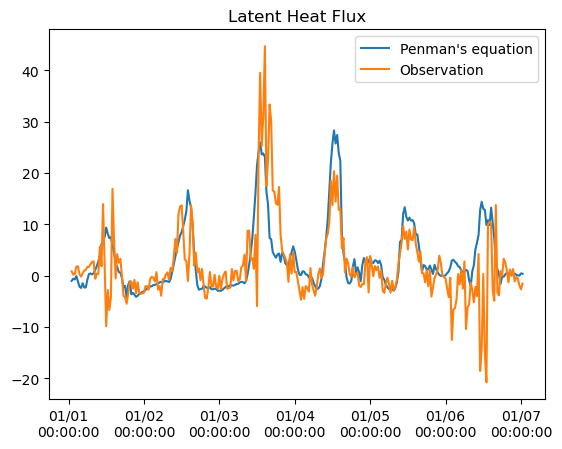

In [125]:
#プロット
fig,ax = plt.subplots()
ax.plot(date,LE,label="Penman's equation")
ax.plot(date,df['Qle'][day_start:day_end],label='Observation')
#ax.plot(date,df['Wind'][:days],label='wind_velocity')

ax.set_title("Latent Heat Flux")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M:%S"))
ax.legend()
plt.show()
fig.savefig('./png/penman_lE_winter.png')

### Sensible Heat Flux

In [117]:
H = RN - LE - 0 #熱収支式から求める

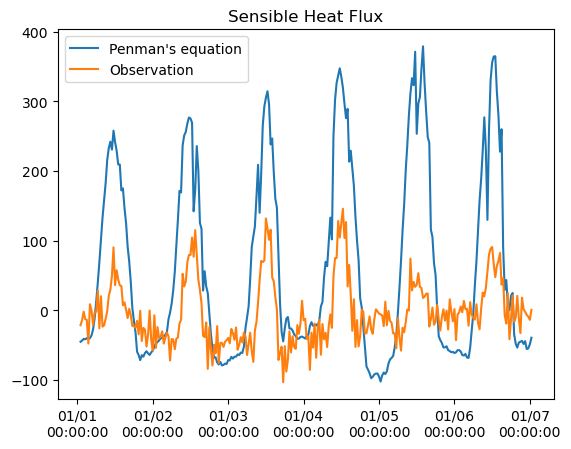

In [126]:
#プロット
fig,ax = plt.subplots()
ax.plot(date,H,label="Penman's equation")
ax.plot(date,df['Qh'][day_start:day_end],label='Observation')

ax.set_title("Sensible Heat Flux")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M:%S"))
ax.legend()
plt.show()
fig.savefig('./png/penman_H_winter.png')

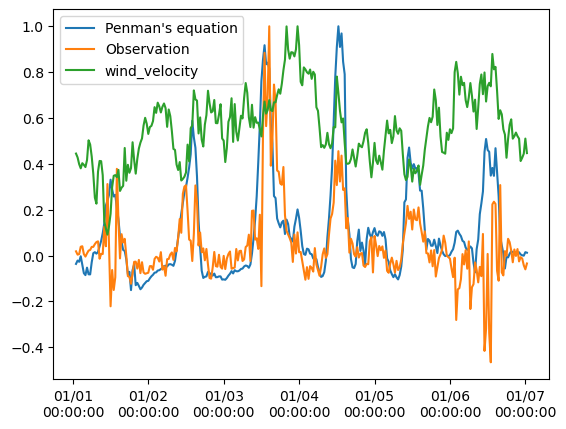

In [102]:
#正規化したプロット
fig,ax = plt.subplots()
ax.plot(date,LE/max(abs(LE)),label="Penman's equation")
ax.plot(date,df['Qle'][:days]/max(abs(df['Qle'][:days])),label='Observation')
ax.plot(date,df['Wind'][:days]/max(abs(df['Wind'][:days])),label='wind_velocity')

ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%H:%M:%S"))
ax.legend()
plt.show()

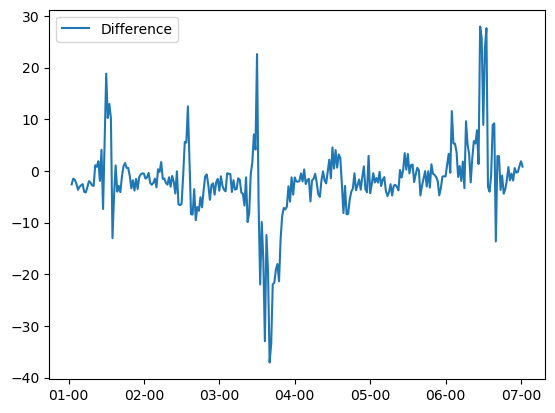

In [90]:
#潜熱の差をプロット
fig,ax = plt.subplots()
ax.plot(date,LE-df['Qle'][:days],label="Difference")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%H"))
ax.legend()
plt.show()